#   Import Libraries
## Defining the problem statement
For this project, we will be using the data from the Kaggle competition: [Garanti BBCA Data Camp](https://www.kaggle.com/competitions/garanti-bbva-data-camp/overview). In this competition, we will be predicting whether a user will leave the company in 2019 or not.


In [61]:
# Imported Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder
import  sklearn.preprocessing as preprocessing
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

from googletrans import Translator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.pipeline import make_pipeline
'''from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced'''
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


#read all csv files education, languages, skills, etc
df_education = pd.read_csv('education.csv')
df_languages = pd.read_csv('languages.csv')
df_skill = pd.read_csv('skills.csv')
df_work = pd.read_csv('work_experiences.csv')
df_submissions = pd.read_csv('submission.csv')
df_test = pd.read_csv('test_users.csv')
df_recession = pd.read_csv('recession.csv')
df = pd.read_csv('train_users.csv')
# concat df with df_test
df = pd.concat([df, df_test], axis=0, sort=False)
df = df.reset_index(drop=True)
df.moved_after_2019 = df.moved_after_2019.fillna(-1).astype(int) # when splitting we recognize test users
df

,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1
1,6950,Internet,"Istanbul, Istanbul, Turkey",0
2,4880,Online Media,Turkey,0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0
4,11005,Banking,"Istanbul, Turkey",0
...,...,...,...,...
66269,32847,Computer Software,Turkey,-1
66270,20054,Hospital & Health Care,Turkey,-1
66271,7029,Wireless,"Istanbul, Turkey",-1
66272,56130,Information Technology and Services,"Ankara, Turkey",-1


# Data Preprocessing and Feature Engineering

In [62]:
%%time
# Stop words ve stemmer
stop_words = set(stopwords.words('english', 'turkish'))
ps = PorterStemmer()

# df_skill
unique_skills = df_skill['skill'].unique()
skills_dict = {}
for skill in unique_skills:
    skill_lower = skill.lower().replace('[,\.!?(-+_)]','')
    skill_stemmed = ' '.join([ps.stem(w) for w in word_tokenize(skill_lower) if not w in stop_words])
    skills_dict[skill] = skill_stemmed

# df_languages
unique_languages = df_languages['language'].unique()
languages_dict = {}
for language in unique_languages:
    language_lower = language.lower().replace('[,\.!?(-+_)]','')
    language_stemmed = ' '.join([ps.stem(w) for w in word_tokenize(language_lower) if not w in stop_words])
    languages_dict[language] = language_stemmed

# df_education
df_education['degree'] = df_education['degree'].fillna('UNKNOWN')
df_education['degree'] = df_education['degree'].astype(str)
unique_degrees = df_education['degree'].unique()
degrees_dict = {}
for degree in unique_degrees:
    degree_lower = degree.lower().replace('[,\.!?(-+_)]','')
    degree_stemmed = ' '.join([ps.stem(w) for w in word_tokenize(degree_lower) if not w in stop_words])
    degrees_dict[degree] = degree_stemmed

# skill column update
df_skill['skill'] = df_skill['skill'].apply(lambda x: skills_dict.get(x, 'UNKNOWN'))

# language column update
df_languages['language'] = df_languages['language'].apply(lambda x: languages_dict.get(x, 'UNKNOWN'))

# degree column update
df_education['degree'] = df_education['degree'].apply(lambda x: degrees_dict.get(x, 'UNKNOWN'))


CPU times: total: 1.91 s
Wall time: 6.91 s


In [63]:
%%time
# Translator nesnesi oluşturun
translator = Translator()
# Çeviri işlemini gerçekleştiren fonksiyon
def translate_unique_values(temp, col, chunk_size=150, src='auto', dest='en'):
    # Unique değerleri alın
    unique_values = temp[col].unique()

    # Tüm unique değerleri birleştir
    text = ','.join(unique_values)

    # Parçalar halinde çevir ve sonuçları birleştir
    results = []
    for i in range(0, len(text), chunk_size):
        results.append(translator.translate(text[i:i+chunk_size], src=src, dest=dest).text)

    # Sonuçları tekrar parçalara ayır
    translated_text = ''.join(results)
    translated_values = translated_text.split(',')

    # Yeni çevrilmiş değerleri DataFrame'e kaydet
    new_df = temp.copy()
    new_df[col] = new_df[col].apply(lambda x: translated_values[unique_values.tolist().index(x)] if x in unique_values else x)
    return new_df

df_languages = translate_unique_values(df_languages, 'language', chunk_size=150, src='auto', dest='en')
df_languages['language'] = df_languages['language'].str.strip().str.lower()
df_languages['proficiency'] = df_languages['proficiency'].str.strip().str.lower()
language_list = ['british', 'english']
proficiency_list = ['limited_working', 'professional_working', 'native_or_bilingual', 'full_professional']

df = pd.merge(df,  df_languages[df_languages.language.isin(language_list) & df_languages.proficiency.isin(proficiency_list)].groupby('user_id')['proficiency'].nunique().reset_index(name='lang'), on='user_id', how='left')
df.lang = df.lang.fillna(0).astype(int)

df_education['degree'] = df_education['degree'].str.strip().str.lower()

high_school_list = [np.NAN, 'unknown', 'lise', 'ortaokul', 'high school', 'middle school', 'high school diploma', 'önlisans', 'ön lisans', 'lise mezunu', 'high school graduate', 'ortaokul mezunu', 'middle school graduate']

df = pd.merge(df, df_education[~df_education.degree.isin(high_school_list)].groupby('user_id')['degree'].nunique().reset_index(name='edu'), on='user_id', how='left')

df['edu'] = df['edu'].fillna(0).astype(int)

CPU times: total: 406 ms
Wall time: 11.4 s


In [4]:
%%time
df_skill = pd.merge(df_skill, df[['user_id', 'industry']], on='user_id')
df_combinations = df_skill.groupby(['skill', 'industry']).size().reset_index(name='count')
df_combinations = df_combinations[df_combinations['count'] > 5]
df_combinations = df_combinations[(df_combinations['skill'] != 'UNKNOWN') & (df_combinations['skill'] != '')]

combinations_scores = pd.DataFrame(columns=['skill', 'industry', 'score'])
# Kombinasyonların tekrar sayısının logaritmasını alarak puanlandırma
for i, combination in enumerate(df_combinations.itertuples()):
    user_count = combination.count
    score = 1 / np.log(user_count)
    combinations_scores.loc[i] = [combination.skill, combination.industry, score]

# Her bir kullanıcının yetenek skorlarını hesaplayan fonksiyon
score_table = pd.DataFrame(columns=['user_id', 'ability_score'])
def calculate_user_scores(user_group):
    user_skills = set(user_group['skill'])
    industry = user_group['industry'].iloc[0] # Tüm satırlar aynı endüstriye sahip olduğu için iloc[0] kullanıyoruz

    # Her bir kombinasyon için kullanıcının yetenek skorunu hesapla
    score_total = combinations_scores[combinations_scores['skill'].isin(user_skills) & (combinations_scores['industry'] == industry)]['score'].sum()
    #add to score table
    score_table.loc[len(score_table)] = [int(user_group['user_id'].iloc[0]), score_total]


df_skill.groupby('user_id').apply(lambda x: calculate_user_scores(x))

df = pd.merge(df, score_table, on='user_id', how='left')
df.ability_score = df.ability_score.fillna(df.ability_score.median())
#normalize ability score
scaler = preprocessing.MinMaxScaler()
df['ability_score'] = scaler.fit_transform(df['ability_score'].values.reshape(-1,1))
df

CPU times: total: 1min 25s
Wall time: 4min 8s


,user_id,industry,location,moved_after_2019,lang,edu,ability_score
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1,1,2,0.171312
1,6950,Internet,"Istanbul, Istanbul, Turkey",0,1,1,0.401332
2,4880,Online Media,Turkey,0,0,2,0.224450
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0,0,2,0.266735
4,11005,Banking,"Istanbul, Turkey",0,1,0,0.225832
...,...,...,...,...,...,...,...
66269,32847,Computer Software,Turkey,-1,0,0,0.027347
66270,20054,Hospital & Health Care,Turkey,-1,1,3,0.014560
66271,7029,Wireless,"Istanbul, Turkey",-1,1,2,0.067713
66272,56130,Information Technology and Services,"Ankara, Turkey",-1,1,1,0.090133


In [5]:
%%time
df_work.rename(columns={'start_year_month': 'start_date'}, inplace=True)
df_work['start_date'] = df_work['start_date'].astype(str)
df_work['start_date'] = pd.to_datetime(df_work['start_date'], format='%Y%m')


df_work = df_work.sort_values(by=['user_id', 'start_date'])
df_work.drop_duplicates(subset=['user_id', 'company_id'], keep='first', inplace=True)

df_work['work_time'] = df_work.groupby('user_id')['start_date'].apply(lambda x: x.diff().shift(-1))
df_work.work_time = df_work.work_time.dt.days
df_work = df_work[df_work.work_time != 0]

df_work.work_time.fillna((pd.to_datetime('2019-12-31') - df_work['start_date']).dt.days, inplace=True)

df_work['company_avg_work_time'] = df_work.groupby('company_id')['work_time'].transform('mean')

df_work['user_company_diff'] = df_work['work_time'] - df_work['company_avg_work_time']
df_work['user_working_point'] = df_work.groupby('user_id')['user_company_diff'].apply(lambda x: x.cumsum())

df_work['experinece'] = df_work.groupby('user_id')['work_time'].apply(lambda x: x.cumsum())
df_work['experinece'] = df_work['experinece'] / 365



df_work['user_working_point'] = scaler.fit_transform(df_work['user_working_point'].values.reshape(-1,1))
df_work.drop(['user_company_diff'], axis=1, inplace=True)

# sort by date, group by with user_id and take the last row for each user_id and then merge with df dataframe
df = pd.merge(df, df_work.sort_values(by=['user_id', 'start_date']).groupby('user_id').last()[['company_id','company_avg_work_time','experinece','user_working_point']], on='user_id', how='left')
df.location.fillna(df.location.mode()[0], inplace=True)
df.industry.fillna(df.industry.mode()[0], inplace=True)
df['company_id'] = df['company_id'].fillna(-1).astype(int)
df.fillna(0, inplace=True)

df

CPU times: total: 7.3 s
Wall time: 20.6 s


,user_id,industry,location,moved_after_2019,lang,edu,ability_score,company_id,company_avg_work_time,experinece,user_working_point
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1,1,2,0.171312,1343,834.000000,4.671233,0.493045
1,6950,Internet,"Istanbul, Istanbul, Turkey",0,1,1,0.401332,1337,542.700935,6.753425,0.539867
2,4880,Online Media,Turkey,0,0,2,0.224450,4366,791.400000,6.000000,0.519722
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0,0,2,0.266735,26,1119.048246,10.336986,0.619892
4,11005,Banking,"Istanbul, Turkey",0,1,0,0.225832,1562,1198.036320,10.336986,0.529757
...,...,...,...,...,...,...,...,...,...,...,...
66269,32847,Computer Software,Turkey,-1,0,0,0.027347,2143,667.408163,3.501370,0.554056
66270,20054,Hospital & Health Care,Turkey,-1,1,3,0.014560,14463,1676.384615,14.339726,0.567971
66271,7029,Wireless,"Istanbul, Turkey",-1,1,2,0.067713,4913,747.745536,1.501370,0.518021
66272,56130,Information Technology and Services,"Ankara, Turkey",-1,1,1,0.090133,34,919.090153,5.586301,0.535299


In [11]:
%%time
df_work.drop(['location'], axis=1, inplace=True)
df_work = pd.merge(df_work, df, on='user_id', how='outer')
df_work = df_work[~df_work['moved_after_2019'].isna()]
df_work[['Q1', 'Q2', 'Q3', 'Q4']] = [0.0, 0.0, 0.0, 0.0]
def set_moved_after_2019(x):
    x['moved_after_2019'].iloc[:-1] = 1
    x['Q1'].iloc[-1] = 0.763488
    x['Q2'].iloc[-1] = 0.528342
    x['Q3'].iloc[-1] = 0.311781
    x['Q4'].iloc[-1] = 0.203649
    if x['company_id_x'].isna().values[0]:
        print(x['user_id'])
        x['company_id_x'] = x['company_id_y']
        x['company_avg_work_time_x'] = x['company_avg_work_time_y']
        x['experinece_x'] = x['experinece_y']
        x['user_working_point_x'] = x['user_working_point_y']
        x['work_time'] = 0.0
    return x

df_work = df_work.groupby('user_id').apply(set_moved_after_2019)

df_work.drop(['company_id_y', 'company_avg_work_time_y', 'experinece_y', 'user_working_point_y'], axis=1, inplace=True)
df_work.rename(columns={'company_id_x': 'company_id', 'company_avg_work_time_x': 'company_avg_work_time', 'experinece_x': 'experinece', 'user_working_point_x': 'user_working_point'}, inplace=True)


temp = df_recession[df_recession.SUBJECT.str.contains('B1_GE') & df_recession.MEASURE.str.contains('GPSA') & df_recession.Country.str.contains('OECD - Europe')][['Period', 'Value']]
df_recession = df_recession[df_recession.SUBJECT.str.contains('B1_GE') & df_recession.MEASURE.str.contains('GPSA') & df_recession.Country.str.contains('Türkiye')][['Period', 'Value']]
df_recession = pd.concat([df_recession, temp[~temp.Period.isin(df_recession.Period)]])
#start_date i 1985 den önce olanları 1985 e çekiyoruz
df_work.loc[df_work['start_date'] < '1985-06-01', 'start_date'] = pd.to_datetime('1985-06-01')

def get_recession_values(x, start_date, work_time):

    if x['Q1'] != 0.0:
        return x[['Q1', 'Q2', 'Q3', 'Q4']]

    else:
        # Start date'den work time kadar gün ekleyerek bitiş tarihini hesapla
        end_date = start_date + pd.DateOffset(days=work_time)
        if end_date > pd.to_datetime('2019-06-01'):
            end_date = pd.to_datetime('2019-06-01')

        if 0 < end_date.month < 4:
            end_date = end_date.replace(month=1, day=15)
        elif 3 < end_date.month < 7:
            end_date = end_date.replace(month=4, day=15)
        elif 6 < end_date.month < 10:
            end_date = end_date.replace(month=7, day=15)
        else:
            end_date = end_date.replace(month=10, day=15)
        # 4 ay önceki tarihi hesapla
        four_months_before = end_date - pd.DateOffset(months=4)
        # 4 ay sonraki tarihi hesapla
        four_months_after = end_date + pd.DateOffset(months=4)

        # start_date, six_months_before ve six_months_after tarihlerini Q dönemlerine dönüştür
        quarters = pd.period_range(four_months_before, four_months_after, freq='Q').strftime('Q%q-%Y')
        # df_recession dataframe'indeki Value değerlerini Q dönemlerine göre grupla
        return df_recession.set_index('Period').loc[quarters]['Value'].values.tolist()

# df_work dataframe'indeki her bir rowa Q1, Q2, Q3, Q4 kolonları ekle
df_work[['Q1', 'Q2', 'Q3', 'Q4']] = pd.DataFrame(df_work.apply(lambda x: get_recession_values(x,x['start_date'], x['work_time']), axis=1, result_type="expand"))

df_work.drop(['start_date','company_id', 'user_working_point'], axis=1, inplace=True)
df_work.industry.fillna(df_work.industry.mode()[0], inplace=True)
df_work.location.fillna(df_work.location.mode()[0], inplace=True)
df_work

CPU times: total: 42.7 s
Wall time: 1min 45s


,user_id,work_time,company_avg_work_time,experinece,industry,location,moved_after_2019,lang,edu,ability_score,Q1,Q2,Q3,Q4
0,0,5234.0,3305.000000,14.339726,Computer Software,Turkey,0,0,0,0.124922,0.763488,0.528342,0.311781,0.203649
1,2,182.0,182.000000,0.498630,Electrical/Electronic Manufacturing,Turkey,1,0,1,0.041645,5.509612,1.368865,2.280319,1.515919
2,2,365.0,1369.500000,1.498630,Electrical/Electronic Manufacturing,Turkey,1,0,1,0.041645,1.882761,1.468743,0.657522,-1.627936
3,2,578.0,562.750000,3.082192,Electrical/Electronic Manufacturing,Turkey,-1,0,1,0.041645,0.763488,0.528342,0.311781,0.203649
4,5,943.0,629.333333,2.583562,Computer Software,"Kocaeli, Turkey",0,0,2,0.081747,0.763488,0.528342,0.311781,0.203649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164959,15539,0.0,0.000000,0.000000,Information Technology and Services,"İzmir, İzmir, Turkey",-1,0,1,0.124922,0.763488,0.528342,0.311781,0.203649
164960,54811,0.0,0.000000,0.000000,Higher Education,"Ankara, Ankara, Turkey",-1,0,1,0.124922,0.763488,0.528342,0.311781,0.203649
164961,32644,0.0,0.000000,0.000000,Computer Software,"Ankara, Ankara, Turkey",-1,0,1,0.054892,0.763488,0.528342,0.311781,0.203649
164962,53267,0.0,0.000000,0.000000,Automotive,Turkey,-1,1,1,0.194636,0.763488,0.528342,0.311781,0.203649


In [14]:
%%time
def get_location(x):
    if len(x.split(',')) == 3:
        return x.split(',')[1].strip()
    elif len(x.split(',')) == 2:
        return x.split(',')[0].strip()
    elif ',' not in x and ' ' in x:
        return x.split(' ')[1].strip()
    else:
        return x

df.location = df.location.str.lower()
df.location = df.location.apply(lambda x: get_location(x))
df_work.location = df_work.location.str.lower()
df_work.location = df_work.location.apply(lambda x: get_location(x))

#updating location values with the most common values
df.loc[df['location'].map(df['location'].value_counts()) < 400, 'location'] = 'turkey'
df_work.loc[df_work['location'].map(df_work['location'].value_counts()) < 900, 'location'] = 'turkey'

label = preprocessing.LabelEncoder()
df['industry'] = label.fit_transform(df['industry'])
df['location'] = label.fit_transform(df['location'])
df_work['industry'] = label.fit_transform(df_work['industry'])
df_work['location'] = label.fit_transform(df_work['location'])

val1 = df[df['moved_after_2019'] == -1]
train1 = df[df['moved_after_2019'] != -1]
val2 = df_work[df_work['moved_after_2019'] == -1]
train2 = df_work[df_work['moved_after_2019'] != -1]

Target = ['moved_after_2019']
#define x variables for original features aka feature selection
data1_x = ['industry', 'location','lang','edu','ability_score','company_avg_work_time','experinece','user_working_point']
data2_x = ['user_id', 'work_time', 'company_avg_work_time', 'experinece',
           'industry', 'location', 'lang', 'edu',
           'ability_score', 'Q1', 'Q2', 'Q3', 'Q4']
data1_x_calc = []
data1_xy = []

#define x variables for original w/bin features to remove continuous variables
data1_x_bin = []
data1_xy_bin = []

#define x and y variables for dummy features original
data1_dummy = []
data1_x_dummy = []
data1_xy_dummy = []

CPU times: total: 156 ms
Wall time: 319 ms


In [38]:
data2_x = ['company_avg_work_time', 'experinece',
           'industry', 'lang', 'edu',
           'ability_score', 'Q1', 'Q2', 'Q3', 'Q4']

In [39]:
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(  n_estimators=200, class_weight='imbalanced_subsample', random_state=42)
cv  = StratifiedKFold(shuffle=True, random_state=42)

scores = cross_val_score(clf,train2[data2_x], train2[Target], cv=cv, scoring='accuracy')

In [35]:
print(f'Scores mean: {np.mean(scores):.4f}')
print(f'Scores std: {np.std(scores):.4f}')

Scores mean: 0.9454
Scores std: 0.0011


In [36]:
clf.fit(train2[data2_x], train2[Target])
val2[Target] = clf.predict(val2[data2_x]).reshape(-1,1)
val2.moved_after_2019.value_counts()


#df_submissions.loc[val2.index, Target] = clf.predict(val2)

#df_submissions[Target] = df_submissions[Target].astype(int)
#df_submissions[Target].value_counts()

0    10920
1     2335
Name: moved_after_2019, dtype: int64

In [37]:
#submit file
submit = val2[['user_id','moved_after_2019']]
submit.to_csv("../submit.csv", index=False)

print('Validation Data Distribution: \n', val2['moved_after_2019'].value_counts(normalize = True))
submit.sample(10)

Validation Data Distribution: 
 0    0.82384
1    0.17616
Name: moved_after_2019, dtype: float64


,user_id,moved_after_2019
50248,21412,0
162364,29707,0
138227,59583,0
135357,58379,0
87855,37363,1
16526,7142,1
89799,38053,0
85348,36345,0
164186,45952,0
70203,30085,0


In [ ]:
['company_avg_work_time' 'experinece' 'user_working_point']
AFTER DT RFE Test w/bin score mean: 82.88
AFTER DT RFE Test w/bin score 3*std: +/- 0.61
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'random_state': 0}

# TRAINING


In [57]:
%%time
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),


    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = train1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train1[data1_x], train1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!


    #save MLA predictions - see section 6 for usage
    alg.fit(train1[data1_x], train1[Target])
    MLA_predict[MLA_name] = alg.predict(train1[data1_x])

    row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

CPU times: total: 3min 12s
Wall time: 3min 30s


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",NaN,0.869999,0.006078,4.072077
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",NaN,0.862498,0.007085,2.08354
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",NaN,0.858355,0.005036,1.238196
17,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",NaN,0.841412,0.006724,0.987042
13,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",NaN,0.825569,0.011069,0.166269
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",NaN,0.820389,0.005865,3.936567
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",NaN,0.807802,0.0087,1.049229
14,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",NaN,0.800245,0.01152,0.025765
12,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",NaN,0.760348,0.008896,0.045973
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",NaN,0.699799,0.004851,2.411881


In [10]:
cv_results

{'fit_time': array([0.88239908, 0.87338877, 0.85712838, 0.86183333, 0.86131072,
        0.86231065, 0.85129499, 0.85143638, 0.85902238, 0.87497067]),
 'score_time': array([0.01356554, 0.00852251, 0.00902462, 0.00901532, 0.01003289,
        0.01007366, 0.01353407, 0.01003003, 0.00902677, 0.00851846]),
 'test_score': array([0.83911731, 0.84402112, 0.84358104, 0.83949453, 0.84502703,
        0.84068905, 0.84257513, 0.83760845, 0.84087766, 0.84112913])}

Text(0, 0.5, 'Algorithm')

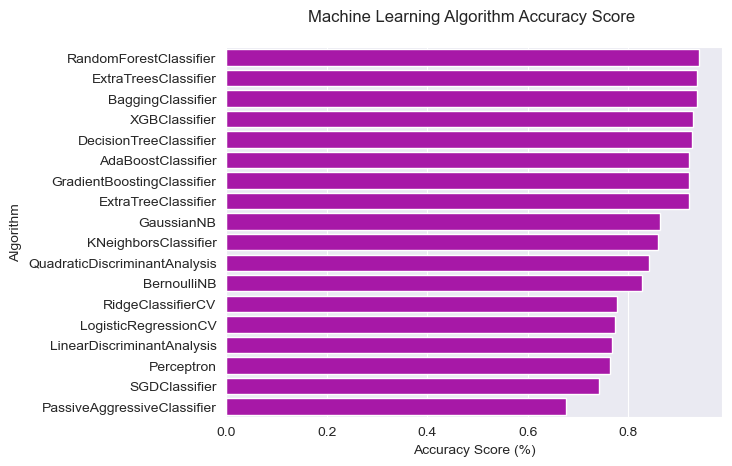

In [41]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [59]:
for i in range(0, len(MLA)):
    val1[Target] = MLA[i].predict(val1[data1_x]).reshape(-1,1)
    print(MLA[i].__class__.__name__, ':\t' , i)
    print(val1.moved_after_2019.value_counts())

AdaBoostClassifier :	 0
0    11447
1     1808
Name: moved_after_2019, dtype: int64
BaggingClassifier :	 1
0    11673
1     1582
Name: moved_after_2019, dtype: int64
ExtraTreesClassifier :	 2
0    11380
1     1875
Name: moved_after_2019, dtype: int64
GradientBoostingClassifier :	 3
0    11510
1     1745
Name: moved_after_2019, dtype: int64
RandomForestClassifier :	 4
0    11607
1     1648
Name: moved_after_2019, dtype: int64
LogisticRegressionCV :	 5
0    11001
1     2254
Name: moved_after_2019, dtype: int64
PassiveAggressiveClassifier :	 6
0    10779
1     2476
Name: moved_after_2019, dtype: int64
RidgeClassifierCV :	 7
0    9812
1    3443
Name: moved_after_2019, dtype: int64
SGDClassifier :	 8
0    12104
1     1151
Name: moved_after_2019, dtype: int64
Perceptron :	 9
0    10921
1     2334
Name: moved_after_2019, dtype: int64
BernoulliNB :	 10
1    9120
0    4135
Name: moved_after_2019, dtype: int64
GaussianNB :	 11
1    7907
0    5348
Name: moved_after_2019, dtype: int64
KNeighborsCla

In [60]:
val1[Target] = MLA[7].predict(val1[data1_x]).reshape(-1,1)
#submit file
submit = val1[['user_id','moved_after_2019']]
submit.to_csv("../submission.csv", index=False)

In [54]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree,  train2[data2_x], train2[Target], cv  = cv_split)
dtree.fit( train2[data2_x], train2[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
#print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100))
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
              }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit( train2[data2_x], train2[Target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
#print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


#duplicates gridsearchcv
#tune_results = model_selection.cross_validate(tune_model, data1[data1_x_bin], data1[Target], cv  = cv_split)

#print('AFTER DT Parameters: ', tune_model.best_params_)
#print("AFTER DT Training w/bin set score mean: {:.2f}". format(tune_results['train_score'].mean()*100))
#print("AFTER DT Test w/bin set score mean: {:.2f}". format(tune_results['test_score'].mean()*100))
#print("AFTER DT Test w/bin set score min: {:.2f}". format(tune_results['test_score'].min()*100))
#print('-'*10)

BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Test w/bin score mean: 92.72
BEFORE DT Test w/bin score 3*std: +/- 0.39
----------
AFTER DT Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'random_state': 0}
AFTER DT Test w/bin score mean: 97.24
AFTER DT Test w/bin score 3*std: +/- 0.19
----------


In [55]:
#base model
print('BEFORE DT RFE Training Shape Old: ',  train2[data2_x].shape)
print('BEFORE DT RFE Training Columns Old: ',  train2[data2_x].columns.values)

#print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit( train2[data2_x], train2[Target])

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = train2[data2_x].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, train2[X_rfe], train2[Target], cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', train2[X_rfe].shape)
print('AFTER DT RFE Training Columns New: ', X_rfe)

#print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100))
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(train2[X_rfe], train2[Target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
#print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (151709, 11)
BEFORE DT RFE Training Columns Old:  ['company_avg_work_time' 'experinece' 'industry' 'location' 'lang' 'edu'
 'ability_score' 'Q1' 'Q2' 'Q3' 'Q4']
BEFORE DT RFE Test w/bin score mean: 92.72
BEFORE DT RFE Test w/bin score 3*std: +/- 0.39
----------
AFTER DT RFE Training Shape New:  (151709, 6)
AFTER DT RFE Training Columns New:  ['company_avg_work_time' 'experinece' 'industry' 'edu' 'ability_score'
 'Q3']
AFTER DT RFE Test w/bin score mean: 92.76
AFTER DT RFE Test w/bin score 3*std: +/- 0.39
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'entropy', 'max_depth': 10, 'random_state': 0}
AFTER DT RFE Tuned Test w/bin score mean: 97.23
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 0.21
----------


In [56]:
val2[Target] = rfe_tune_model.predict(val2[X_rfe]).reshape(-1,1)
val2.moved_after_2019.value_counts()

0    11972
1     1283
Name: moved_after_2019, dtype: int64

In [ ]:
#Graph MLA version of Decision Tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
dot_data = tree.export_graphviz(dtree, out_file=None,
                                feature_names = data1_x_bin, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
#compare algorithm predictions with each other, where 1 = exactly similar and 0 = exactly opposite
#there are some 1's, but enough blues and light reds to create a "super algorithm" by combining them
correlation_heatmap(MLA_predict)

In [15]:
#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),


    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),

    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),

    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),

    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard,  train1[data1_x], train1[Target], cv  = cv_split)
vote_hard.fit( train1[data1_x], train1[Target])

#print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100))
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train1[data1_x], train1[Target], cv  = cv_split)
vote_soft.fit( train1[data1_x], train1[Target])

#print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100))
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Test w/bin score mean: 84.98
Hard Voting Test w/bin score 3*std: +/- 0.49
----------
Soft Voting Test w/bin score mean: 86.13
Soft Voting Test w/bin score 3*std: +/- 0.63
----------


In [16]:
import time

#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
    [{
        #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
        'n_estimators': grid_n_estimator, #default=50
        'learning_rate': grid_learn, #default=1
        #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
        'random_state': grid_seed
    }],


    [{
        #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
        'n_estimators': grid_n_estimator, #default=10
        'max_samples': grid_ratio, #default=1.0
        'random_state': grid_seed
    }],


    [{
        #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'random_state': grid_seed
    }],


    [{
        #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
        #'loss': ['deviance', 'exponential'], #default=’deviance’
        'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
        'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
        #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
        'max_depth': grid_max_depth, #default=3
        'random_state': grid_seed
    }],


    [{
        #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
        'random_state': grid_seed
    }],

    [{
        #GaussianProcessClassifier
        'max_iter_predict': grid_n_estimator, #default: 100
        'random_state': grid_seed
    }],


    [{
        #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
        'fit_intercept': grid_bool, #default: True
        #'penalty': ['l1','l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
        'random_state': grid_seed
    }],


    [{
        #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
        'alpha': grid_ratio, #default: 1.0
    }],


    #GaussianNB -
    [{}],

    [{
        #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
        'n_neighbors': [1,2,3,4,5,6,7], #default: 5
        'weights': ['uniform', 'distance'], #default = ‘uniform’
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],


    [{
        #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
        #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
        #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [1,2,3,4,5], #default=1.0
        'gamma': grid_ratio, #edfault: auto
        'decision_function_shape': ['ovo', 'ovr'], #default:ovr
        'probability': [True],
        'random_state': grid_seed
    }],


    [{
        #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
        'learning_rate': grid_learn, #default: .3
        'max_depth': [1,2,4,6,8,10], #default 2
        'n_estimators': grid_n_estimator,
        'seed': grid_seed
    }]
]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)


    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit( train1[data1_x], train1[Target])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 490.13 seconds.
The best parameter for BaggingClassifier is {'max_samples': 1.0, 'n_estimators': 300, 'random_state': 0} with a runtime of 1797.05 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300, 'random_state': 0} with a runtime of 503.32 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'random_state': 0} with a runtime of 2292.24 seconds.


In [ ]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard,  train1[data1_x], train1[Target], cv  = cv_split)
grid_hard.fit( train1[data1_x], train1[Target])

#print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft,  train1[data1_x], train1[Target], cv  = cv_split)
grid_soft.fit( train1[data1_x], train1[Target])

#print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


#12/31/17 tuned with data1_x_bin
#The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 33.39 seconds.
#The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 30.28 seconds.
#The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 64.76 seconds.
#The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 34.35 seconds.
#The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 76.32 seconds.
#The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 6.01 seconds.
#The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'} with a runtime of 8.04 seconds.
#The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.19 seconds.
#The best parameter for GaussianNB is {} with a runtime of 0.04 seconds.
#The best parameter for KNeighborsClassifier is {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'} with a runtime of 4.84 seconds.
#The best parameter for SVC is {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 29.39 seconds.
#The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 46.23 seconds.
#Total optimization time was 5.56 minutes.

In [ ]:
alg = MLA[0]

In [19]:
val1[data1_x]

,industry,location,lang,edu,ability_score,company_avg_work_time,experinece,user_working_point
53019,118,5,0,2,0.334197,1345.021127,19.008219,0.585160
53020,25,2,1,3,0.210421,1119.048246,3.583562,0.516951
53021,9,5,1,1,0.105192,0.000000,0.000000,0.000000
53022,67,5,0,1,0.336394,505.666667,8.421918,0.583754
53023,36,5,1,0,0.026839,496.333333,3.583562,0.560535
...,...,...,...,...,...,...,...,...
66269,25,5,0,0,0.027347,667.408163,3.501370,0.554056
66270,57,5,1,3,0.014560,1676.384615,14.339726,0.567971
66271,139,2,1,2,0.067713,747.745536,1.501370,0.518021
66272,63,0,1,1,0.090133,919.090153,5.586301,0.535299


In [24]:
data2_x = ['user_id', 'company_id_x', 'work_time', 'company_avg_work_time_x',
           'user_working_point_x', 'experinece_x', 'industry', 'location', 'lang', 'edu', 'ability_score', 'Q1', 'Q2', 'Q3', 'Q4']

In [26]:
train2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151709 entries, 0 to 162234
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  151709 non-null  int64  
 1   company_id_x             145243 non-null  float64
 2   work_time                145243 non-null  float64
 3   company_avg_work_time_x  145243 non-null  float64
 4   user_working_point_x     145243 non-null  float64
 5   experinece_x             145243 non-null  float64
 6   industry                 151709 non-null  int32  
 7   location                 151709 non-null  int32  
 8   lang                     151709 non-null  int32  
 9   edu                      151709 non-null  int32  
 10  ability_score            151709 non-null  float64
 11  Q1                       151709 non-null  float64
 12  Q2                       151709 non-null  float64
 13  Q3                       151709 non-null  float64
 14  Q4  

In [30]:
print(val1.info())
print("-"*10)
submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
submit_dt.fit(train2[data2_x], train2[Target])
print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
val1[Target] = rfe_tune_model.predict(val1[X_rfe]).reshape(-1,1)
val1.moved_after_2019.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13255 entries, 53019 to 66273
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                13255 non-null  int64  
 1   industry               13255 non-null  int32  
 2   location               13255 non-null  int32  
 3   moved_after_2019       13255 non-null  int32  
 4   lang                   13255 non-null  int32  
 5   edu                    13255 non-null  int32  
 6   ability_score          13255 non-null  float64
 7   company_id             13255 non-null  int32  
 8   company_avg_work_time  13255 non-null  float64
 9   experinece             13255 non-null  float64
 10  user_working_point     13255 non-null  float64
dtypes: float64(4), int32(6), int64(1)
memory usage: 932.0 KB
None
----------


0    11760
1     1495
Name: moved_after_2019, dtype: int64

In [ ]:
#prepare data for modeling
print(val1.info())
print("-"*10)
#data_val.sample(10)



#handmade decision tree - submission score = 0.77990
#val1['moved_after_2019'] = mytree(data_val).astype(int)


#decision tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_dt = tree.DecisionTreeClassifier()

submit_dt = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
submit_dt.fit(train1[data1_x], train1[Target])
print('Best Parameters: ', submit_dt.best_params_) #Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
val1[Target] = submit_dt.predict(val1[data1_x])


#bagging w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77990
#submit_bc = ensemble.BaggingClassifier()
#submit_bc = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid= {'n_estimators':grid_n_estimator, 'max_samples': grid_ratio, 'oob_score': grid_bool, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_bc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_bc.best_params_) #Best Parameters:  {'max_samples': 0.25, 'n_estimators': 500, 'oob_score': True, 'random_state': 0}
#data_val['Survived'] = submit_bc.predict(data_val[data1_x_bin])


#extra tree w/full dataset modeling submission score: defaults= 0.76555, tuned= 0.77990
#submit_etc = ensemble.ExtraTreesClassifier()
#submit_etc = model_selection.GridSearchCV(ensemble.ExtraTreesClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_etc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_etc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_etc.predict(data_val[data1_x_bin])


#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205
#submit_rfc = ensemble.RandomForestClassifier()
#submit_rfc = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'n_estimators': grid_n_estimator, 'criterion': grid_criterion, 'max_depth': grid_max_depth, 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_rfc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}
#data_val['Survived'] = submit_rfc.predict(data_val[data1_x_bin])



#ada boosting w/full dataset modeling submission score: defaults= 0.74162, tuned= 0.75119
#submit_abc = ensemble.AdaBoostClassifier()
#submit_abc = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid={'n_estimators': grid_n_estimator, 'learning_rate': grid_ratio, 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_abc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_abc.best_params_) #Best Parameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}
#data_val['Survived'] = submit_abc.predict(data_val[data1_x_bin])


#gradient boosting w/full dataset modeling submission score: defaults= 0.75119, tuned= 0.77033
#submit_gbc = ensemble.GradientBoostingClassifier()
#submit_gbc = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid={'learning_rate': grid_ratio, 'n_estimators': grid_n_estimator, 'max_depth': grid_max_depth, 'random_state':grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_gbc.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_gbc.best_params_) #Best Parameters:  {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 50, 'random_state': 0}
#data_val['Survived'] = submit_gbc.predict(data_val[data1_x_bin])

#extreme boosting w/full dataset modeling submission score: defaults= 0.73684, tuned= 0.77990
#submit_xgb = XGBClassifier()
#submit_xgb = model_selection.GridSearchCV(XGBClassifier(), param_grid= {'learning_rate': grid_learn, 'max_depth': [0,2,4,6,8,10], 'n_estimators': grid_n_estimator, 'seed': grid_seed}, scoring = 'roc_auc', cv = cv_split)
#submit_xgb.fit(data1[data1_x_bin], data1[Target])
#print('Best Parameters: ', submit_xgb.best_params_) #Best Parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0}
#data_val['Survived'] = submit_xgb.predict(data_val[data1_x_bin])


#hard voting classifier w/full dataset modeling submission score: defaults= 0.75598, tuned = 0.77990
#data_val['Survived'] = vote_hard.predict(data_val[data1_x_bin])
#val1['moved_after_2019'] = grid_hard.predict(val1[data1_x])


#soft voting classifier w/full dataset modeling submission score: defaults= 0.73684, tuned = 0.74162
#data_val['Survived'] = vote_soft.predict(data_val[data1_x_bin])
#data_val['Survived'] = grid_soft.predict(data_val[data1_x_bin])


#submit file
submit = val1[['user_id','moved_after_2019']]
submit.to_csv("../working/submit.csv", index=False)

print('Validation Data Distribution: \n', val1['moved_after_2019'].value_counts(normalize = True))
submit.sample(10)

Hi! My name is Mehmet Ünlü
(Daymenion on all social media)
============================
Jr. Machine Learning Enginer and Data Scientist

### Socials

<p align="left"> <a href="https://www.github.com/daymenion" target="_blank" rel="noreferrer"><img src="https://th.bing.com/th/id/R.f12560820c5070ee4be83c3feb569ce1?rik=l9Xz9PiZqqnDJQ&pid=ImgRaw&r=0" width="64" height="64" /></a> <a href="http://www.instagram.com/daymenion" target="_blank" rel="noreferrer"><img src="https://th.bing.com/th/id/R.a11315201911a2d50acb12f211af971d?rik=rYfbAN81u748Ww&pid=ImgRaw&r=0" width="64" height="64" /></a> <a href="https://www.linkedin.com/in/daymenion" target="_blank" rel="noreferrer"><img src="https://th.bing.com/th/id/R.94fdd92844139dece578d7a6c773af6e?rik=g%2bRCje2rfTDYZw&pid=ImgRaw&r=0" width="64" height="64" /></a> <a href="http://www.medium.com/@daymenion" target="_blank" rel="noreferrer"><img src="https://cdn.freebiesupply.com/logos/thumbs/2x/medium-1-logo.png" width="64" height="64" /></a>  <a href="https://www.youtube.com/c/daymenion" target="_blank" rel="noreferrer"><img src="https://th.bing.com/th/id/R.81cea6fc47a319de6ad49c00eda309e4?rik=n3DSWqmh0wO5KA&pid=ImgRaw&r=0" width="64" height="64" /></a></p>